In [1]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
import datetime
import io
import requests
import urllib.request

from tqdm import tqdm
from functools import reduce
from climata.usgs import DailyValueIO
from shapely.geometry import Point
from shapely.ops import cascaded_union


In [18]:
# Spatial join usgs gauges to butte co / gw model combined area

gdf = gp.read_file("../shape/usgs_gauges.shp")
butte_gwm = gp.read_file("../shape/butte_gw_model.shp")
butte_gwm = butte_gwm.to_crs("EPSG:4326")
#overlap_gdf = butte_gwm.union(gp.read_file("../shape/study_area/Butte_co_rpj.shp"))
#overlap_gdf = gp.GeoDataFrame(geometry = overlap_gdf)
#overlap_gdf.set_crs = "EPSG:4326"

gauges_within = gp.sjoin(gdf.to_crs(crs="EPSG:4326"), gp.GeoDataFrame(butte_gwm, crs="EPSG:4326"), how='inner', op='within')
#gauges_within = gp.sjoin(gdf.to_crs(crs="EPSG:4326"), gp.GeoDataFrame(overlap_gdf, crs="EPSG:4326"), how='inner', op='within')
gauges_within.to_file("../shape/gauges_in_butte_sub.shp")

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  if sys.path[0] == '':


In [19]:
# Read the station level discharge data 
data_dir = "../data/discharge"
inflow_dir = os.path.join(data_dir,"inflow")
outflow_dir = os.path.join(data_dir,"outflow")

In [20]:
incsvs = [os.path.join(inflow_dir,x) for x in os.listdir(inflow_dir)]
indfs = [pd.read_csv(x, sep = '\t') for x in incsvs]

In [21]:
outcsvs = [os.path.join(outflow_dir,x) for x in os.listdir(outflow_dir)]
outdfs = [pd.read_csv(x, sep = '\t') for x in outcsvs]

In [22]:
def filter_dfs(dflist):
    
    dfs_filt = []
    
    for df in dflist:

        # Get site id
        gauge_id = str(df['site_no'].unique()[0])
        outcolname = '{}_q_km3'.format(gauge_id)

        # Ft^3 / s to km^3 / mon
        df[outcolname] = df['mean_va'] * 2.83168e-11 * 2.628e+6

        # Get datetime 
        dtlist = []
        for idx, row in df[['year_nu','month_nu']].iterrows():
            dt = datetime.datetime(year=row['year_nu'], month=row['month_nu'], day=1)
            dtlist.append(dt)

        df.index = dtlist
        df = df[(df.index < '2022-06-01') & (df.index >= '2000-01-01')]
        dfs_filt.append(df[[outcolname]])
        
    return pd.concat(dfs_filt, axis = 1)

In [23]:
indf = pd.DataFrame(filter_dfs(indfs).sum(axis = 1))
indf.columns = ['inflow_km3']
outdf = pd.DataFrame(filter_dfs(outdfs).sum(axis = 1))
outdf.columns = ['outflow_km3']

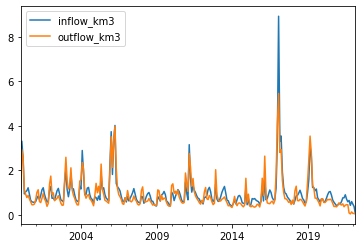

In [24]:
pd.concat([indf,outdf], axis = 1).plot()

In [9]:
indf.to_csv("../data/inflow_butte_sub.csv")
outdf.to_csv("../data/outflow_butte_sub.csv")

In [10]:
ingauges = [x.replace("_q_km3","") for x in filter_dfs(indfs).columns]
outgauges = [x.replace("_q_km3","") for x in filter_dfs(outdfs).columns]

In [15]:
gdf = gp.read_file("../shape/usgs_gauges.shp")
butte_gwm = gp.read_file("../shape/butte_gw_model.shp")
overlap_gdf = butte_gwm.union(gp.read_file("../shape/Butte_co_rpj.shp"))
overlap_gdf = gp.GeoDataFrame(geometry = overlap_gdf)
overlap_gdf.set_crs = "EPSG:4326"

gauges_within = gp.sjoin(gdf, gp.GeoDataFrame(overlap_gdf).to_crs("EPSG:4326"), how='inner', predicate='within')
gauges_within.to_file("../shape/gauges_in_butte.shp")

/home/tea/anaconda3/envs/plswork/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_10400/1463921799.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gauges_within.to_file("../shape/gauges_in_butte.shp")


<AxesSubplot:>

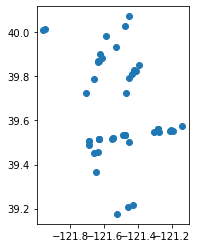

In [12]:
gauges_within.plot()

In [13]:
gauges_within['gauge_id'].values

array(['11395500', '11396000', '11396090', '11396200', '11396290',
       '11396310', '11396395', '11396396', '11396397', '11406818',
       '11406819', '11406820', '11404330', '11404360', '11404380',
       '11404400', '11404500', '11404900', '11405085', '11405120',
       '11405200', '11420750', '11420770', '11421000', '11383500',
       '11383515', '11389720', '11389740', '11389747', '11389750',
       '11389775', '11389780', '11389800', '11390000', '11406880',
       '11406890', '11406900', '11396329', '11396330', '11406810',
       '11406848', '11406849', '11406850', '11406910', '11406920',
       '11406930', '11406999', '11407000', '11407150'], dtype=object)